In [37]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data,DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_batch
from tqdm import tqdm
import numpy as np
import json
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
import torch_geometric.nn as pyg_nn
from sklearn.model_selection import train_test_split

In [5]:
## Reading in Data

plays_data = pd.read_csv("data/plays.csv")
player_data = pd.read_csv("data/players.csv")
player_play_data = pd.read_csv("data/player_play.csv")
game_data = pd.read_csv("data/games.csv")

passing_plays = plays_data[plays_data["passResult"].isin(["C", "I", "IN"])]

In [53]:
## Helper Functions

def get_edge_weights(Receiver, Defender):
    # Current Vector = [ x, y, speed, acceleration, orientation, direction of motion, Receiver/Defender? ]

    weights = []
    for i in range(len(Receiver)):
        for j in range(len(Defender)):
            point1 = np.array([Receiver[i][0], Receiver[i][1]])
            point2 = np.array([Defender[j][0], Defender[j][1]])

            dist = np.linalg.norm(point2 - point1)

            weights.append(dist)

    return weights


# Finding targeted node
def get_targeted_receiver(Recs, nflIDs):
    
    for WR in Recs.itertuples(index=True):
        if (WR.wasTargettedReceiver):
            return np.where(nflIDs == WR.nflId)[0][0]
        
    return None
        
def adjust_position(row, game, play):

    row = row.copy()

    if play["possessionTeam"].iloc[0] == game["homeTeamAbbr"].iloc[0]:
        if play["yardlineSide"].iloc[0] == game["homeTeamAbbr"].iloc[0]:
            absYard = play["yardlineNumber"].iloc[0] + 10
        elif play["yardlineSide"].iloc[0] == game["visitorTeamAbbr"].iloc[0]:
            absYard = 110 - play["yardlineNumber"].iloc[0]
        else:
            absYard = 60

        row.loc["x"] -= absYard
        row.loc["o"] += 90
        row.loc["dir"] += 90
        if row["o"] > 360: row["o"] -= 360
        if row["dir"] > 360: row["dir"] -= 360

    elif play["possessionTeam"].iloc[0] == game["visitorTeamAbbr"].iloc[0]:
        if play["yardlineSide"].iloc[0] == game["visitorTeamAbbr"].iloc[0]:
            absYard = 110 - play["yardlineNumber"].iloc[0]
        elif play["yardlineSide"].iloc[0] == game["homeTeamAbbr"].iloc[0]:
            absYard = play["yardlineNumber"].iloc[0] + 10
        else:
            absYard = 60

        row.loc["x"] = absYard - row["x"]
        row.loc["y"] = 53.3 - row["y"]
        row.loc["o"] += 270
        row.loc["dir"] += 270
        if row["o"] > 360: row["o"] -= 360
        if row["dir"] > 360: row["dir"] -= 360

    else:
        print("SOMETHING WENT WRONG")

    return row

def get_target(target, playFrames, Recs, Defs):
    frame = playFrames[(playFrames["event"] == "pass_arrived")]

    WR_frame = frame[(frame["nflId"]) == Recs.iloc[int(target)]["nflId"]]

    closest = 9999

    for _, Def in Defs.iterrows():
        Def_frame = frame[(frame["nflId"] == Def["nflId"])]

        point1 = np.array([WR_frame["x"].values[0], WR_frame["y"].values[0]])
        point2 = np.array([Def_frame["x"].values[0], Def_frame["y"].values[0]])

        dist = np.linalg.norm(point2 - point1)

        if dist < closest:
            closest = dist

    return closest

# Find QB on a given play
def get_qb(row, qb_list):
    all_player_data = player_play_data[(player_play_data["gameId"] == row.gameId) & (player_play_data["playId"] == row.playId)]

    # Find any player on the play who is in the QB list
    qbs_on_play = all_player_data[all_player_data["nflId"].isin(qb_list["nflId"])]

    if not qbs_on_play.empty:
        return qbs_on_play.iloc[0]["nflId"]  # or return the whole row if you want more info
    else:
        print("QB NOT FOUND")
        return None


In [56]:
all_data_qb = []

# Getting list of all QBs
qb_list = player_data[player_data["position"] == "QB"][["displayName", "nflId"]]

for i in range(9):
    week = 1 + i

    # ----- Getting List of Valid Play Ids ----- #
    # Getting tracking data at moment of pass
    week_data = pd.read_csv("data/tracking_week_" + str(week) + ".csv")

    # Getting data of passing plays in week
    week_data_passed = week_data[week_data["event"].isin(["pass_forward", "pass_shovel"])]
    week_data_arrived = week_data[week_data["event"].isin(["pass_arrived"])]

    # Get (gameId, playId) pairs where a pass was thrown
    passed_plays = week_data_passed[["gameId", "playId"]].drop_duplicates()

    # Get (gameId, playId) pairs where the pass arrived
    arrived_plays = week_data_arrived[["gameId", "playId"]].drop_duplicates()

    # Keep only the (gameId, playId) pairs that are in both
    valid_plays = pd.merge(passed_plays, arrived_plays, on=["gameId", "playId"], how="inner")   # Passing plays for this week from tracking data

    # Ensuring the dataset is sorted to plays with a completion, incompletion, or interception
    passing_play_Ids = passing_plays[["gameId", "playId"]].drop_duplicates()    # ALL PASSING PLAYS WEEKS 1-9 from passing_plays

    # Get playIds for this week that are either C, I, or IN and have both pass_forward/pass_shovel and pass_arrived
    playIds = pd.merge(valid_plays, passing_play_Ids, on=["gameId", "playId"], how="inner")     # In theory, this shouldn't do much


    # ----- Editing Tracking Data ----- #
    # Filtering to only post snap plays
    post_snap_data = week_data[week_data["frameType"].isin(["AFTER_SNAP"])]

    # Sorting by plays with completions, incompletions, and interceptions
    week_data_plays = post_snap_data.merge(playIds, on=["gameId", "playId"])

    # Filter post_snap_data to only include valid plays in playIds
    passing_post_snap_data = pd.merge(post_snap_data, playIds, on=["gameId", "playId"], how="inner")

    # ----- Beginning graph_data Creation ----- #

    for i,row in tqdm(enumerate(playIds.itertuples(index=True)), total=len(playIds), desc= "Week " + str(week) + " Processing Plays", unit="play"):

        # ----- Getting Constants between Frames ----- #

        # Initializing play_data
        play_data = []

        # Getting list of eligible receivers and defenders in coverage
        Recs = player_play_data[(player_play_data["gameId"] == row.gameId) & (player_play_data["playId"] == row.playId) & (player_play_data["wasRunningRoute"] == True)]
        Defs = player_play_data[(player_play_data["gameId"] == row.gameId) & (player_play_data["playId"] == row.playId) & ~pd.isna(player_play_data["pff_defensiveCoverageAssignment"])]

        # Creating edges array:  size = [2, len(Receivers) * len(Defenders)]
        R_nodes = np.arange(len(Recs))
        D_nodes = np.arange(len(Recs), len(Defs) + len(Recs))
        edges = np.vstack([np.repeat(R_nodes, len(Defs)), np.tile(D_nodes, len(Recs))])

        # Creating edges array with nflIds
        R_nodes2 = Recs["nflId"].values
        D_nodes2 = Defs["nflId"].values
        nflIDs = np.concatenate([Recs["nflId"].values, Defs["nflId"].values])       # List of nflIds
        edgeIDs = np.vstack([np.repeat(R_nodes2, len(Defs)), np.tile(D_nodes2, len(Recs))])     # Structured edgeIds

        playFrames = passing_post_snap_data[(passing_post_snap_data["gameId"] == row.gameId) & (passing_post_snap_data["playId"] == row.playId)]

        # Getting frameId for frame of pass_thrown
        frame = playFrames[(playFrames["event"] == "pass_forward") | (playFrames["event"] == "pass_shovel")]
        frameId = frame.iloc[0]["frameId"]

        # ----- Getting current game and play data ----- #
        # Getting current game and play data
        curr_game = game_data[game_data["gameId"] == row.gameId]
        curr_play = plays_data[(plays_data["gameId"] == row.gameId) & (plays_data["playId"] == row.playId)]

        # Getting targeted Receiver
        target = get_targeted_receiver(Recs, nflIDs)
        if target is None:
            continue
        target_y = get_target(target, playFrames, Recs, Defs)
        if target_y > 1000:
            continue

        # Getting QB on the play
        qb = get_qb(row, qb_list)

        # ----- Getting Frame specific data ----- #
        for j in range(30):     # Iterating for 30 frames
            frameId -= 1

            matching_rows = playFrames[playFrames["frameId"] == frameId]
            if matching_rows.empty:
                break

            graph_data = {}

            # Creating vectors of node data for each player
            # Current Vector = [ x, y, speed, acceleration, orientation, direction of motion, Offense/Defense?, Target? ]
            Receivers = []
            for i,WR in enumerate(Recs.itertuples(index=True)):
                WR_row = playFrames[(playFrames["nflId"] == WR.nflId) & (playFrames["frameId"] == frameId)].iloc[0]

                # Adjusting position data
                WR_row = adjust_position(WR_row, curr_game, curr_play)

                Receivers.append([WR_row["x"], WR_row["y"], WR_row["s"], WR_row["a"], WR_row["o"], WR_row["dir"], 1])   # 1 = Offensive Player
                if i == target:
                    Receivers[i].append(1)
                else:
                    Receivers[i].append(0)

            Defenders = []
            for Def in Defs.itertuples(index=True):
                Def_row = playFrames[(playFrames["nflId"] == Def.nflId) & (playFrames["frameId"] == frameId)].iloc[0]
                
                # Adjusting position data
                Def_row = adjust_position(Def_row, curr_game, curr_play)
                
                Defenders.append([Def_row["x"], Def_row["y"], Def_row["s"], Def_row["a"], Def_row["o"], Def_row["dir"], 0, 0])     # 0 = Defensive Player

            # Getting edge weights
            graph_data["edge_weights"] = get_edge_weights(Receivers, Defenders)
            graph_data["receivers"] = Receivers
            graph_data["defenders"] = Defenders
            graph_data["edges"] = edges
            graph_data["y"] = target_y


            play_data.append(graph_data)

        play_data.append(qb)
        all_data_qb.append(play_data)


Week 9 Processing Plays: 100%|██████████| 604/604 [02:38<00:00,  3.81play/s]


In [ ]:
## Dumping week data to a json

# df = pd.DataFrame(all_data_qb)
# df.to_csv("all_data_qb.csv")

def convert_ndarrays(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_ndarrays(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_ndarrays(i) for i in obj]
    else:
        return obj

# Convert your list
converted_data = convert_ndarrays(all_data_qb)

# Now dump safely to JSON
with open("all_data.json", "w") as file:
    json.dump(converted_data, file, indent=2)

In [45]:
def convert_frame_to_pyg(frame_dict):
    # Stack receiver and defender features into node feature matrix
    x = frame_dict["receivers"] + frame_dict["defenders"]
    x = torch.tensor(x, dtype=torch.float)  # [num_nodes, num_features]

    # Edge indices
    edge_index = torch.tensor(frame_dict["edges"], dtype=torch.long)  # [2, num_edges]
    edge_attr = torch.tensor(frame_dict["edge_weights"], dtype=torch.float).unsqueeze(1)  # [num_edges, 1]

    # Ensure edge indices and weights match in length
    assert len(frame_dict["edges"][0]) == len(frame_dict["edge_weights"]), "Edges and edge_weights mismatch"

    # Create a mask for the target receiver
    if x.shape[1] > 7:
        is_target = (x[:, 7] == 1).float()  # If this is the target receiver (based on column 7)
    else:
        is_target = torch.zeros(x.size(0), dtype=torch.bool)

    # Pull target openness label
    if "y" in frame_dict and frame_dict["y"] is not None:
        y = torch.tensor([frame_dict["y"]], dtype=torch.float)
    else:
        y = None  # Handle missing labels gracefully

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, is_target=is_target, y=y)

# Prepare graph data (list of Data objects)
pyg_graphs = []

for play in all_data:
    for frame in play:
        data = convert_frame_to_pyg(frame)
        if data.y is not None:  # Skip frames without a target openness label
            pyg_graphs.append(data)


In [ ]:
class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=8):
        super(GATModel, self).__init__()
        
        # Graph Attention Layer 1
        self.gat1 = pyg_nn.GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        
        # Graph Attention Layer 2
        self.gat2 = pyg_nn.GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=False)
        
        # Fully connected layer for final prediction
        self.fc = nn.Linear(hidden_channels, out_channels)
        
    def forward(self, data):
        # Extract graph data
        x, edge_index, edge_attr, is_target = data.x, data.edge_index, data.edge_attr, data.is_target
        
        # Graph Attention Layers
        x = self.gat1(x, edge_index, edge_attr)
        x = torch.relu(x)  # Apply ReLU activation
        
        x = self.gat2(x, edge_index, edge_attr)
        x = torch.relu(x)  # Apply ReLU activation
        
        # Final output layer
        x = self.fc(x)  # Now x has the shape [num_nodes, out_channels]
        
        # Mask out non-target nodes and return the predicted openness score for the target receiver
        target_openness = x[is_target.to(torch.bool)].squeeze()  # Remove the extra dimension
        
        return target_openness

# Define the model parameters
in_channels = 8  # Number of features for each node (8 features per node)
hidden_channels = 64  # Can be adjusted
out_channels = 1  # Regression output (openness score)


In [49]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your GAT model (assuming you've defined the GATModel class as before)
model = GATModel(in_channels=8, hidden_channels=64, out_channels=1, num_heads=4).to(device)

# Define your optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define your loss function (e.g., Mean Squared Error)
criterion = nn.MSELoss()

# Assuming pyg_graphs is your list of graph data (PyTorch Geometric Data objects)
# Use a DataLoader if you have multiple batches
dataloader = DataLoader(pyg_graphs, batch_size=32, shuffle=True)

# Training loop
num_epochs = 100  # You can change this value based on your needs
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for data in dataloader:  # Iterate over batches of graph data
        data = data.to(device)  # Move the graph data to the GPU
        
        optimizer.zero_grad()  # Reset gradients
        
        # Forward pass (getting the predicted openness score for the target receiver)
        output = model(data)
        
        # Ensure the target label (data.y) is available
        if output is not None and data.y is not None:
            # Compute the loss
            loss = criterion(output, data.y)
            total_loss += loss.item()
            
            # Backward pass (compute gradients)
            loss.backward()
            
            # Update model parameters
            optimizer.step()
    
    # Print the loss for this epoch
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")

# Optionally, save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

Epoch 1, Loss: 8.7662852907535
Epoch 2, Loss: 7.8730421060061655
Epoch 3, Loss: 7.691374077277116
Epoch 4, Loss: 7.5734637268478435
Epoch 5, Loss: 7.463926601878995
Epoch 6, Loss: 7.370835936708494
Epoch 7, Loss: 7.321017094367815
Epoch 8, Loss: 7.234939345488273
Epoch 9, Loss: 7.183885176529776
Epoch 10, Loss: 7.149975258048531
Epoch 11, Loss: 7.100239006325653
Epoch 12, Loss: 7.052720423037688
Epoch 13, Loss: 7.042376588731615
Epoch 14, Loss: 7.008208169680574
Epoch 15, Loss: 6.968671390436376
Epoch 16, Loss: 6.969550091539179
Epoch 17, Loss: 6.931264263251488
Epoch 18, Loss: 6.92338519930672
Epoch 19, Loss: 6.896094380480964
Epoch 20, Loss: 6.885063381397061
Epoch 21, Loss: 6.880695643015258
Epoch 22, Loss: 6.863868560615828
Epoch 23, Loss: 6.847563623424707
Epoch 24, Loss: 6.836632295225404
Epoch 25, Loss: 6.816407207695027
Epoch 26, Loss: 6.818606842428153
Epoch 27, Loss: 6.798035899143912
Epoch 28, Loss: 6.788503308727951
Epoch 29, Loss: 6.770864322228117
Epoch 30, Loss: 6.768323

In [78]:
## Testing QB

# Load trained model
model = GATModel(in_channels=8, hidden_channels=64, out_channels=1, num_heads=4).to(device)
model.load_state_dict(torch.load('models/trained_model.pth'))
model.eval()

results = []

with torch.no_grad():
    for play in tqdm(all_data_qb, desc="Processing plays", unit="play"):
        graphs = []
        
        # Convert all frames in the play to graphs
        for i, frame in enumerate(play):
            if i == len(play) - 1:  # Skipping QB ID frame
                QB_ID = frame
                continue
            graph = convert_frame_to_pyg(frame)
            if graph is not None:
                graphs.append(graph)
        
        if not graphs:
            continue

        # Forward pass for all frames
        predicted_openness_per_frame = []
        offensive_masks = []  # store masks for later alignment

        for graph in graphs:
            graph = graph.to(device)

            x = model.gat1(graph.x, graph.edge_index, graph.edge_attr)
            x = torch.relu(x)
            x = model.gat2(x, graph.edge_index, graph.edge_attr)
            x = torch.relu(x)
            x = model.fc(x).squeeze()

            # Create offensive player mask (7th column = index 6)
            offensive_mask = graph.x[:, 6] == 1
            offensive_masks.append(offensive_mask)

            x = x[offensive_mask]
            predicted_openness_per_frame.append(x.cpu())

        # Use final frame (throw frame) to assess decision
        final_graph = graphs[-1]
        final_scores = predicted_openness_per_frame[-1]
        offensive_mask = offensive_masks[-1]  # final frame's offensive player mask

        is_target = final_graph.is_target.to(torch.bool)

        # Combine is_target with offensive_mask to find the correct offensive target
        target_mask = is_target & offensive_mask

        if target_mask.sum() == 0:
            continue  # no offensive target info, skip

        # Since we masked out non-offensive players, we need index relative to masked list
        # This works because offensive_mask is applied before final_scores is made
        masked_indices = torch.nonzero(offensive_mask, as_tuple=True)[0]
        target_node_idx = torch.nonzero(target_mask, as_tuple=True)[0].item()
        target_idx = (masked_indices == target_node_idx).nonzero(as_tuple=True)[0].item()

        openness_of_target = final_scores[target_idx].item()
        openness_of_best = final_scores.max().item()
        best_idx = final_scores.argmax().item()
        qb_threw_to_most_open = (target_idx == best_idx)

        results.append({
            "qb_threw_to_most_open": qb_threw_to_most_open,
            "openness_of_target": openness_of_target,
            "openness_of_best": openness_of_best,
            "target_idx": int(target_idx),
            "best_idx": int(best_idx),
            "openness_scores": final_scores.tolist(),
            "frame_meta": QB_ID
        })


Processing plays:   0%|          | 0/6774 [00:00<?, ?play/s]

Processing plays: 100%|██████████| 6774/6774 [09:30<00:00, 11.86play/s]


In [ ]:
## Converting results to JSON file

def convert_ndarrays(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_ndarrays(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_ndarrays(i) for i in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return obj.item()  # Converts to native Python int or float
    else:
        return obj

# Convert your list
converted_results = convert_ndarrays(results)

# Now dump safely to JSON
with open("results.json", "w") as file:
    json.dump(converted_results, file, indent=2)

In [93]:
## Analyzing Results

# Reading in results file
results_df = pd.read_json("results.json")

# Intializing Data
QB_results = {}

# Creating dictionary of QB results
for idx, row in results_df.iterrows():
    if row["frame_meta"] not in QB_results:
        QB_results[row["frame_meta"]] = [row["openness_of_best"] - row["openness_of_target"]]
    else:
        QB_results[row["frame_meta"]].append(row["openness_of_best"] - row["openness_of_target"])

qb_summary = []

for qb_id, errors in QB_results.items():
    attempts = len(errors)
    if attempts <= 100:
        continue  # Skip QBs with 100 or fewer attempts

    avg_error = sum(errors) / attempts
    zero_error_count = sum(1 for e in errors if e == 0)
    accuracy = zero_error_count / attempts  # As a float between 0 and 1

    qb_name = player_data[player_data["nflId"] == qb_id]["displayName"].values[0]
    
    qb_summary.append({
        "QB_Name": qb_name,
        "QB_ID": qb_id,
        "Average_Error": avg_error,
        "Attempts": attempts,
        "Accuracy": accuracy
    })

# Convert to DataFrame and sort
qb_summary_df = pd.DataFrame(qb_summary)
qb_summary_df = qb_summary_df.sort_values(by="Average_Error").reset_index(drop=True)
qb_summary_df.to_csv("QB_rankings.csv", index=False)


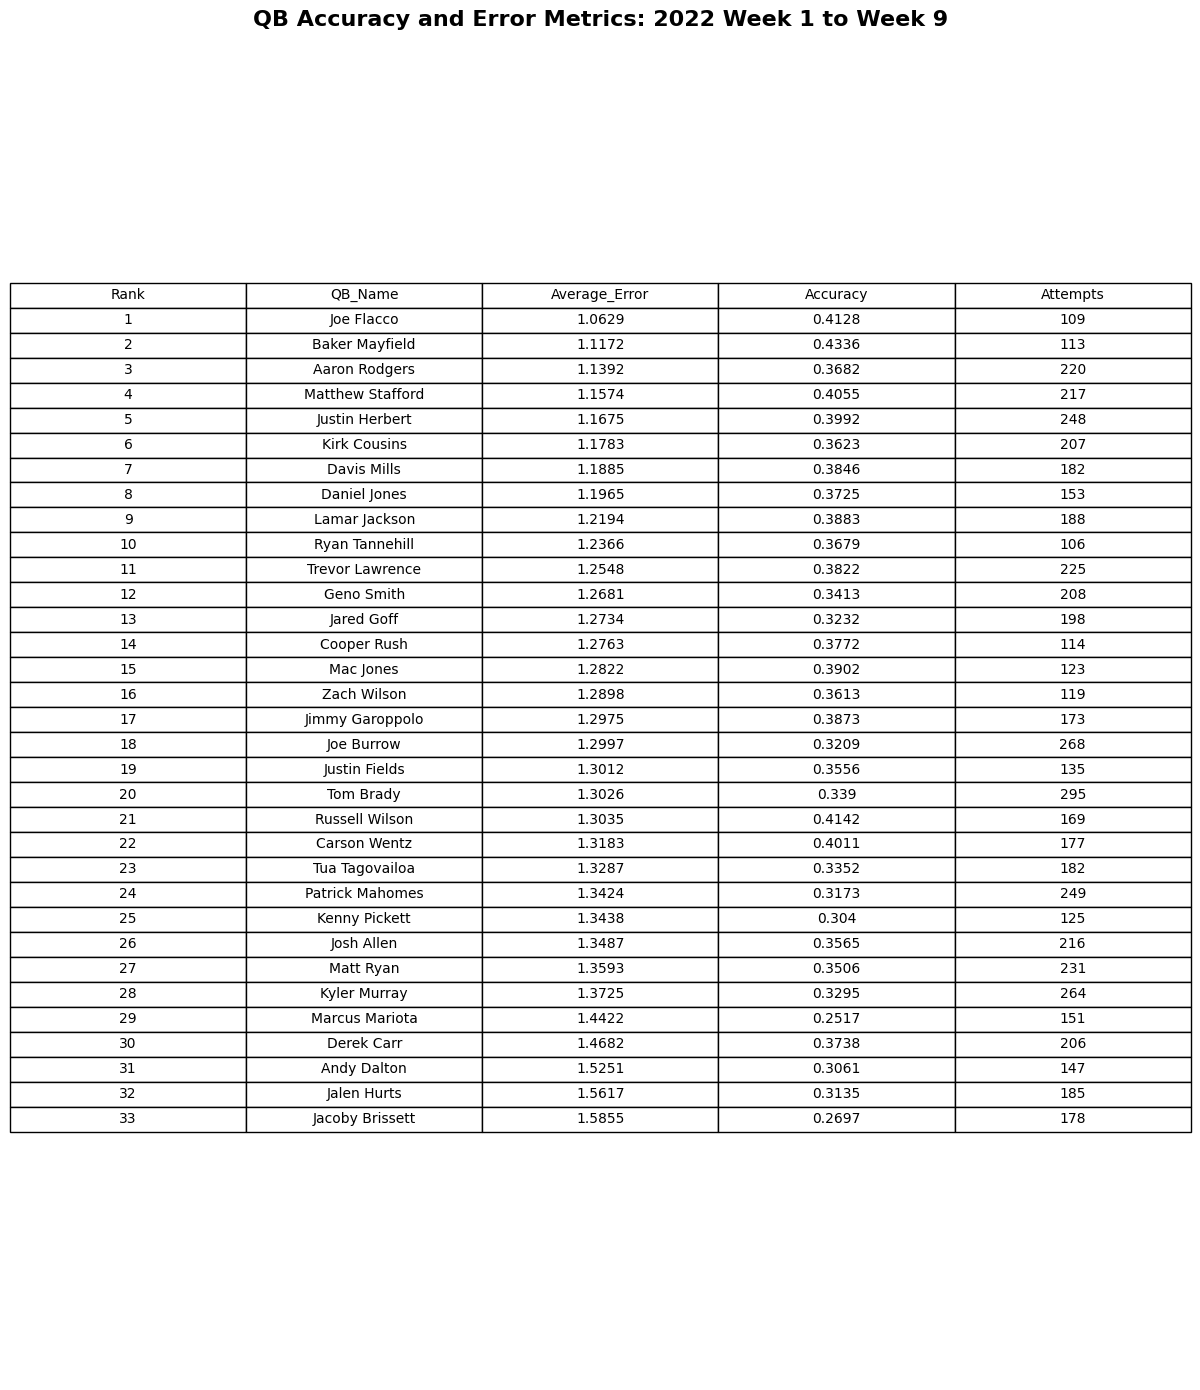

In [ ]:
## Creating Graphics

import matplotlib.pyplot as plt

df = pd.read_csv("QB_rankings.csv")

# Optional: Format columns
df["Average_Error"] = df["Average_Error"].round(4)
df["Accuracy"] = df["Accuracy"].round(4)

df = df[["QB_Name", "Average_Error", "Accuracy", "Attempts"]]

df.insert(0, "Rank", range(1, len(df) + 1))

# Create a figure
fig, ax = plt.subplots(figsize=(12, 14))
ax.axis('off')  # Hide axes

# Create table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust table size

plt.title("QB Accuracy and Error Metrics: 2022 Week 1 to Week 9", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()